# **Content: Stochastic Gradient Descent, Time-series extension, Euclidean distance**

# Part 1
Understanding Stochastic Gradient Descent.
In this exercise, we want to implement [Stochastic Gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) without using a built-in optimizer, to understand how parameters are optimized at the low level.

Let's consider a toy problem of [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression). The data generation process is such that we have one floating point variable $x \in [0,1]$, and one categorical variable $y\in \{0,1\}$. The Logistic Regression problem is to find the optimal parameters for the logistic function to predict the probability of $y$ given $x$.

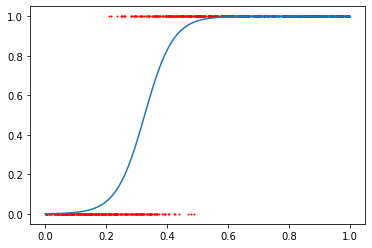

In the image above, the x and y axis correspond to the variables defined previously, with the red "dots" the true data as generated by the process defined below, and the blue line is the optimal logistic decision function learned from the data.

The optimal parameters can be found numerically using gradient descent. In this case, we will be using SGD (batched gradient descent) to optimize the two parameters in the logistic function, $\beta_1, \beta_2$.

If ${p(x)={\frac {1}{1+e^{-(\beta _{1}+\beta _{2}x)}}}}$, then we want to find $\beta_1, \beta_2$ such that the [negative log likelihood](https://en.wikipedia.org/wiki/Likelihood_function) is minimized. In this case, ${\ell =\sum _{k=1}^{K}\left(\,y_{k}\ln(p_{k})+(1-y_{k})\ln(1-p_{k})\right)}$, and the SGD formula is simply:
$\beta_i = \beta_{i-1} - \alpha * \nabla \ell$.

The data generation process as well as the pseudo-code is provided for you below, your task is to fill in the appropriate pytorch code. *Do not use the built-in optimizer*, implement SGD using tensor operations alone.


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

In [ ]:
def generate_data():
  data = torch.rand(1000, 2)
  label = ((data[:,0]+0.3*data[:,1]) > 0.5).to(torch.int)
  return data[:,0], label

tensor(22.0334, grad_fn=<NegBackward0>)
tensor(20.6056, grad_fn=<NegBackward0>)
tensor(16.0593, grad_fn=<NegBackward0>)
tensor(16.0084, grad_fn=<NegBackward0>)
tensor(16.8052, grad_fn=<NegBackward0>)
tensor(14.8225, grad_fn=<NegBackward0>)
tensor(13.3557, grad_fn=<NegBackward0>)
tensor(21.6308, grad_fn=<NegBackward0>)
tensor(16.8106, grad_fn=<NegBackward0>)
tensor(15.3712, grad_fn=<NegBackward0>)
tensor(14.6023, grad_fn=<NegBackward0>)
tensor(14.4928, grad_fn=<NegBackward0>)
tensor(12.6792, grad_fn=<NegBackward0>)
tensor(14.6869, grad_fn=<NegBackward0>)
tensor(12.1206, grad_fn=<NegBackward0>)
tensor(13.4482, grad_fn=<NegBackward0>)
tensor(10.8548, grad_fn=<NegBackward0>)
tensor(12.6252, grad_fn=<NegBackward0>)
tensor(10.3111, grad_fn=<NegBackward0>)
tensor(10.1715, grad_fn=<NegBackward0>)
tensor(9.8148, grad_fn=<NegBackward0>)
tensor(10.8930, grad_fn=<NegBackward0>)
tensor(9.3637, grad_fn=<NegBackward0>)
tensor(10.3861, grad_fn=<NegBackward0>)
tensor(10.8961, grad_fn=<NegBackward0>)
te

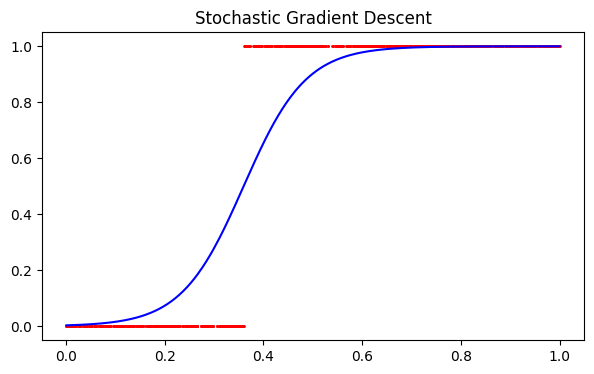

In [ ]:
input, label = generate_data()

# Make minibatches.
inputs = torch.split(input, 32)
labels = torch.split(label, 32)

# Define the two variables to optimize
b1 = torch.autograd.Variable(torch.tensor([0.01]), requires_grad=True)
b2 = torch.autograd.Variable(torch.tensor([0.01]), requires_grad=True)
alpha = 0.1 #added


for epoch in range(15):
  for x, y in zip(inputs,labels):
    # Calculate p_x as per formula above
    z = b1 + b2 * x
    px = 1 / (1 + torch.exp(-z))

    # Calculate the negative loss likelihood
    loss = -torch.sum(y * torch.log(px) + (1 - y) * torch.log(1 - px))

    # Calculate the gradient of the loss w.r.t. the inputs
    b1.retain_grad()
    b2.retain_grad()
    loss.backward()

    # Update the parameters b according to SGD formula
    b1 = b1 - alpha * b1.grad
    b2 = b2 - alpha * b2.grad

    # Print out the loss value
    print(loss)

# Reproduce the image above to validate your result.
outputs = []
yhats = []
for x in input:
  yhat = 1/(1+torch.exp(-(b1+b2*x)))
  yhats.append(yhat.item())
  if yhat > 0.5:
    outputs.append(1)
  else:
    outputs.append(0)
plt.figure(figsize=(7,4))
plt.title("Stochastic Gradient Descent")
plt.scatter(input,outputs, c='r', s=1)

sorted_input, sorted_yhats = zip(*sorted(zip(input, yhats)))
plt.plot(sorted_input, sorted_yhats, color="b", label='Predictions (Blue)')
plt.show()

# Part 2-1

Researchers have measured a bivariate timeseries, but the equipment was unreliable so the data has gaps as well as noise. The data can be found in [data.csv](https://gist.github.com/tmramalho/51733432c88e2b834dbd70353849f887)

In this exercise, we want to train an [MLP](https://en.wikipedia.org/wiki/Multilayer_perceptron) to regress the full observed trajectory from the measured data. Formally, the MLP will be used to approximate the function $f:\mathbb{R} \rightarrow \mathbb{R}^2 ; f(t) = (x(t), y(t))$. In other words, the model takes the current time as an input, and predicts the values of `x` and `y` at that time based only on the measured data.

Your task is to define the data loader, the MLP model and the loss function to complete this task successfully. For this problem you will need to use a regression loss, not a classification loss.

Successful training should result in a data interpolation similar to the below:
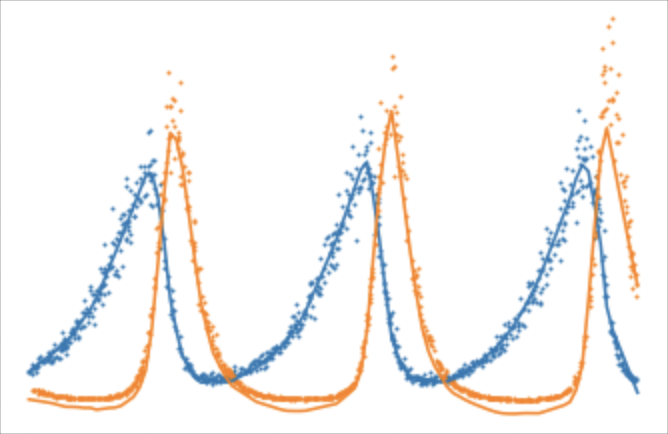

In [ ]:
# Import & Impute raw csv data

def impute_data(url):

  df = pd.read_csv(url)

  # Replace '-' values with Nan, then replace Nan values with the mean
  df = df.replace('-', np.nan)
  df = df.apply(pd.to_numeric, errors='coerce')

  # Sort data by time and fill missing data with fwd and bckwd fill
  df = df.sort_values('t')
  df_ffill = df.ffill()  # Forward fill
  df = df_ffill.bfill()  # Backward fill

  # Add a bit of randomness to imputed data
  nan_mask = df.isna()
  for col in df.columns:
      if col != 't':  # Assuming 't' is a non-numeric or timestamp column
          random_noise = np.random.normal(0, 0.01, size=df[col].shape)
          df[col] += random_noise * nan_mask[col]

  return df

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class TimeSeriesDataset(torch.utils.data.Dataset):

    def __init__(self, csv_file):
      self.times = torch.tensor(df['t'], dtype=torch.float32)
      self.X = torch.tensor(df['x'], dtype=torch.float32)
      self.Y = torch.tensor(df['y'], dtype=torch.float32)

    def __len__(self):
      return len(self.X)

    def __getitem__(self, idx):
      target = torch.stack([self.X[idx], self.Y[idx]])
      return self.times[idx].reshape(1), target

# Import & fill in data from CSV file
data_url = 'https://gist.githubusercontent.com/tmramalho/51733432c88e2b834dbd70353849f887/raw/676636d9e8512963005a318cb9b98060feadb641/data.csv'
df = impute_data(data_url)

BATCH_SIZE = 32

dataset = TimeSeriesDataset(df)

# Shuffle true to make model generalise better to new data
trainloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

def loss_fn(outputs, labels):
  # Measn Squared Error loss function
  return nn.MSELoss()(outputs, labels)

net = Net()

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

In [ ]:
num_epochs = 200
for epoch in range(num_epochs):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 150 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
            running_loss = 0.0

print('Finished Training')

Epoch [1/200], Loss: 13.3613
Epoch [2/200], Loss: 8.4873
Epoch [3/200], Loss: 5.7563
Epoch [4/200], Loss: 4.3178
Epoch [5/200], Loss: 5.3054
Epoch [6/200], Loss: 3.9104
Epoch [7/200], Loss: 4.6326
Epoch [8/200], Loss: 5.2163
Epoch [9/200], Loss: 4.0102
Epoch [10/200], Loss: 2.4349
Epoch [11/200], Loss: 4.5854
Epoch [12/200], Loss: 4.6617
Epoch [13/200], Loss: 2.7901
Epoch [14/200], Loss: 3.7046
Epoch [15/200], Loss: 3.8835
Epoch [16/200], Loss: 3.0916
Epoch [17/200], Loss: 2.0282
Epoch [18/200], Loss: 2.4891
Epoch [19/200], Loss: 3.1618
Epoch [20/200], Loss: 2.0559
Epoch [21/200], Loss: 1.4762
Epoch [22/200], Loss: 2.2606
Epoch [23/200], Loss: 4.8842
Epoch [24/200], Loss: 1.8093
Epoch [25/200], Loss: 1.9322
Epoch [26/200], Loss: 2.3627
Epoch [27/200], Loss: 1.4395
Epoch [28/200], Loss: 1.2806
Epoch [29/200], Loss: 1.3383
Epoch [30/200], Loss: 0.5806
Epoch [31/200], Loss: 0.6277
Epoch [32/200], Loss: 2.4349
Epoch [33/200], Loss: 3.6720
Epoch [34/200], Loss: 0.7607
Epoch [35/200], Loss: 

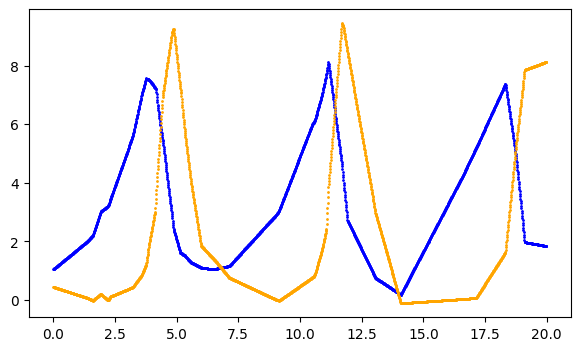

In [ ]:
# Disable dropout and use running stats for batch normalization
net.eval()

# Create 't' values from 0.00 - 20.00 in 0.01 increments
time_values = np.arange(0.00, 20.0, 0.01).reshape(-1, 1)  # Reshape to (N, 1)

# Convert the numpy array to a PyTorch tensor
time_tensor = torch.FloatTensor(time_values)

# Pass time values to model
with torch.no_grad():
    predictions = net(time_tensor)  # Output shape will be (N, 2)

predicted_coordinates = predictions.numpy()
X = []
Y = []

# Separate x and y into respective arrays
for t, (x, y) in zip(time_values.flatten(), predicted_coordinates):
    X.append(x)
    Y.append(y)

# Plot results
plt.figure(figsize=(7,4))
plt.scatter(time_values,X, c='blue', s=1)
plt.scatter(time_values,Y, c='orange', s=1)
plt.show()

# Part 2-2 Time-series extension

The simplified model above will only work well if $t\in[0,20]$.
Create a different model that can extrapolate `x,y` predictions to $t>20$.
Assume that the model has access to the same data as above, and is tasked to predict up to $t=100$. You can change anything in the above setup as needed, including model architecture, loss function, training procedure or data loader.

There are several different correct approaches to tackle this problem, all with different pros and cons, so make sure to explain your reasoning for the different choices made.


In [ ]:
#VERSION 4
import torch.optim as optim

df = impute_data('https://gist.githubusercontent.com/tmramalho/51733432c88e2b834dbd70353849f887/raw/676636d9e8512963005a318cb9b98060feadb641/data.csv')
window = 10

#Length for X and Y will be len(df) - window
train_X = []
train_Y = []
times = []
t = df['t'][window]

#This for loop batches the x and y data into arrays of size "window".
#For example, if window=10, then the (x,y) values from t=0 to t=9 inclusive are used to predict the value of (x, y) at t=10.
for i in range(len(df)-window):
  tx1 = df['x'][i : i+window].to_numpy(dtype=float)
  tx2 = df['y'][i : i+window].to_numpy(dtype=float)

  tx = torch.tensor([tx1, tx2], dtype=torch.float32)
  train_X.append(tx)

  ty = torch.tensor((df['x'][i+window], df['y'][i+window]), dtype=torch.float32)
  train_Y.append(ty)
  times.append(round(t,2))
  t += 0.01

train_X = torch.stack(train_X)
train_Y = torch.stack(train_Y)

input_size = train_X.shape[-1]  #10
hidden_size = 95
output_size = train_Y.shape[-1] #2
num_epochs = 750
learning_rate = 0.002

# Used an LSTM model as they're designed to handle sequential and time-series data well.
# Eg. values of (Xn,Yn) can be determined from previous values (Xn-1 .. Xn-10, Yn-1 .. Yn-10)
# Memory cell retains information over long periods
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

# Model, loss, and optimizer
model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train model
for epoch in range(num_epochs):
    model.train()

    # Forward pass
    outputs = model(train_X)
    loss = criterion(outputs, train_Y)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


<ipython-input-8-5beb925a51f1>:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  tx = torch.tensor([tx1, tx2], dtype=torch.float32)


Epoch [50/750], Loss: 0.7315
Epoch [100/750], Loss: 0.2333
Epoch [150/750], Loss: 0.1605
Epoch [200/750], Loss: 0.1325
Epoch [250/750], Loss: 0.1175
Epoch [300/750], Loss: 0.1093
Epoch [350/750], Loss: 0.1048
Epoch [400/750], Loss: 0.1021
Epoch [450/750], Loss: 0.1003
Epoch [500/750], Loss: 0.0991
Epoch [550/750], Loss: 0.0982
Epoch [600/750], Loss: 0.0974
Epoch [650/750], Loss: 0.0967
Epoch [700/750], Loss: 0.0960
Epoch [750/750], Loss: 0.0954


In [ ]:
# Prediction
output = []
newtimes = torch.arange(20, 100.01, 0.01)
model.eval()

xin = train_X[-1]

# Model makes a prediction on input of length window.
# Then, the last (window-1) elements + the new prediction are used to form a new input array of length window.
# Keep repeating this for t=20 up to t=100
with torch.no_grad():
    for i in range(len(newtimes)):
      prediction = model(xin)
      tx1 = xin[0][1:]
      tx1 = torch.cat((tx1, torch.tensor([prediction[0]])))

      tx2 = xin[1][1:]
      tx2 = torch.cat((tx2, torch.tensor([prediction[1]])))

      xin = torch.stack([tx1, tx2])
      output.append(prediction)

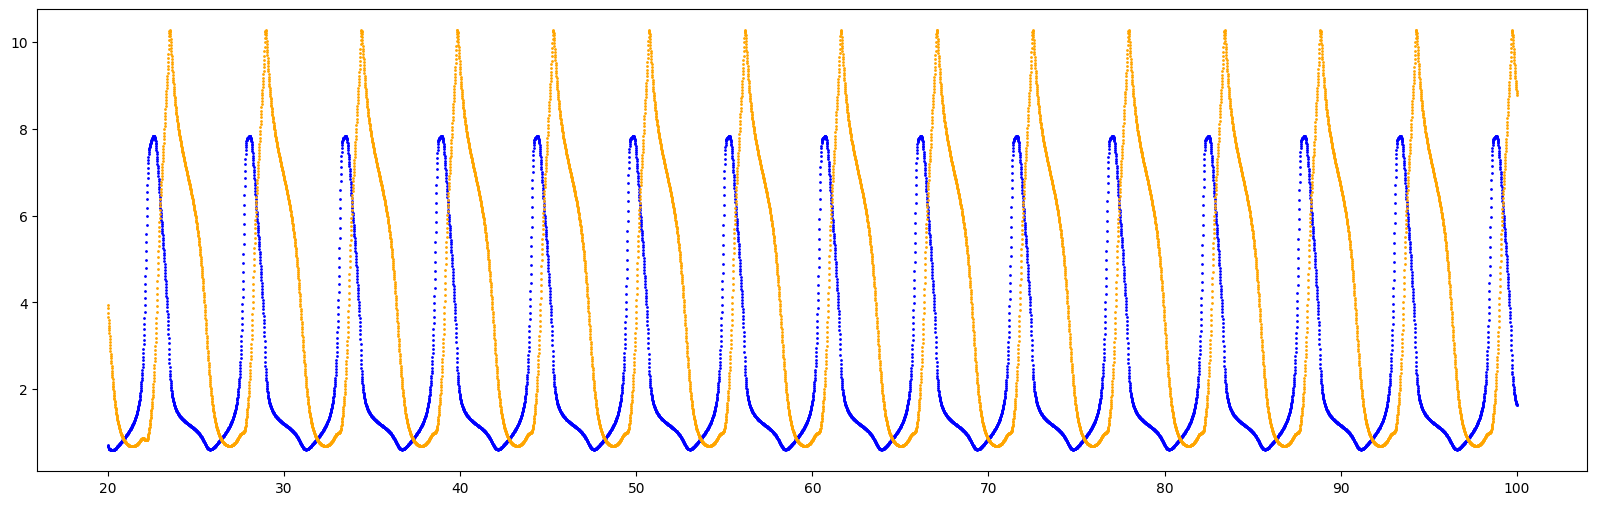

In [ ]:
X = torch.stack([dp[0] for dp in output])
Y = torch.stack([dp[1] for dp in output])

# Plot results
plt.figure(figsize=(20,6))
plt.scatter(newtimes,X, c='blue', s=1)
plt.scatter(newtimes,Y, c='orange', s=1)
plt.show()

# Part 3-1a

Please implement the below function `min_dist`. This function should take a sparse list of 2D coordinates, and map them to a 2D tensor of a specified resolution. The values of each pixel in the tensor should correspond to the [euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between that pixel and the closest pixel which contains a data point.

You can use either numpy or pytorch tensor operations to implement the function. Use only tensor operations, no for-loops are necessary.

Here are the example outputs for the two test cases highlighted below:

Case 1: data at `[0.4, 0.3], [0.6, 0.7]`, resolution 20 pixels.

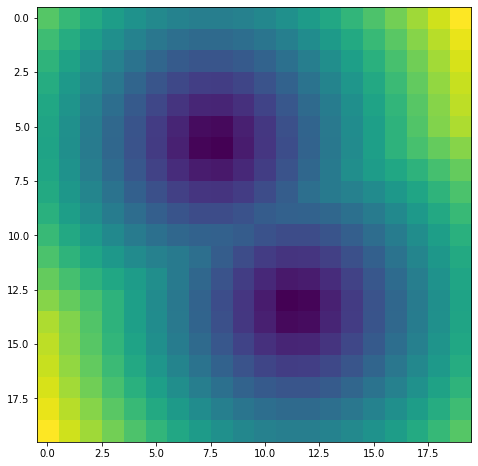


Case 2: data at `[0.4, 0.3], [0.6, 0.7], [0.3, 0.8], [0.5, 0.2]`, resolution 256 pixels.

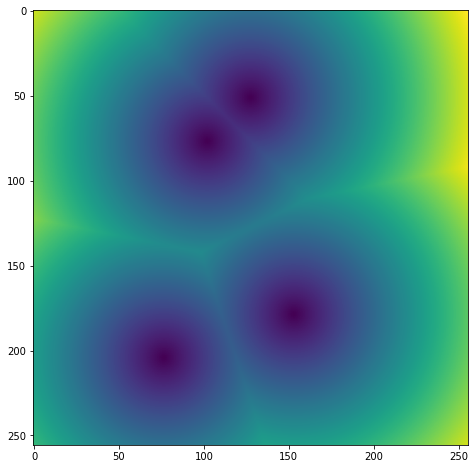


In [ ]:
def min_dist(points, res):
  grid_x, grid_y = torch.meshgrid(torch.linspace(0, 1, res), torch.linspace(0, 1, res), indexing='ij')

  grid = torch.stack((grid_x, grid_y), dim=-1)  # Shape [res, res, 2]

  points = torch.tensor(points).float()  # Shape [points, 2]

  distances = torch.cdist(grid.view(-1, 2), points)  # Shape [res^2, points]

  # Get the min distance for each point on the grid
  min_distances = distances.min(dim=1).values  # Shape: [res^2, 1]

  # Reshape to a res x res tensor
  min_distances_2d = min_distances.view(res, res)

  return min_distances_2d

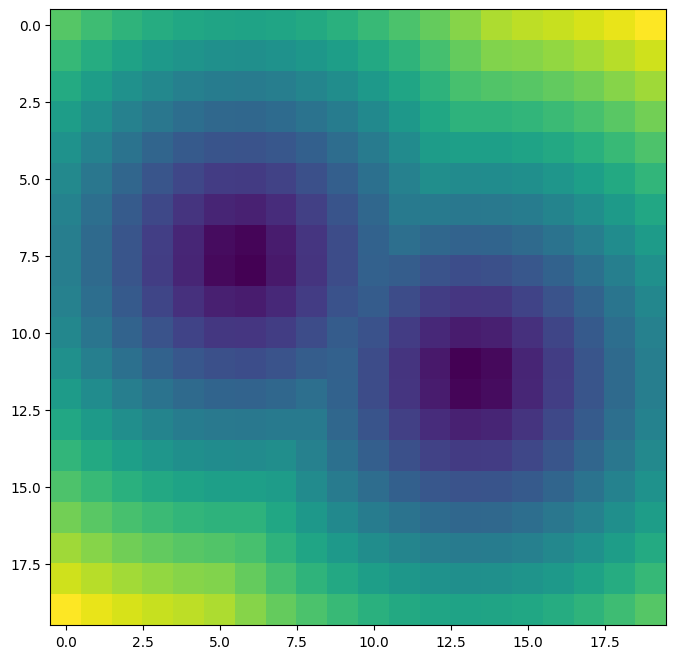

In [ ]:
# Case 1:
distance_to_data = min_dist([[0.4, 0.3], [0.6, 0.7]], 20)
plt.figure(figsize=(8, 8))
plt.imshow(distance_to_data)

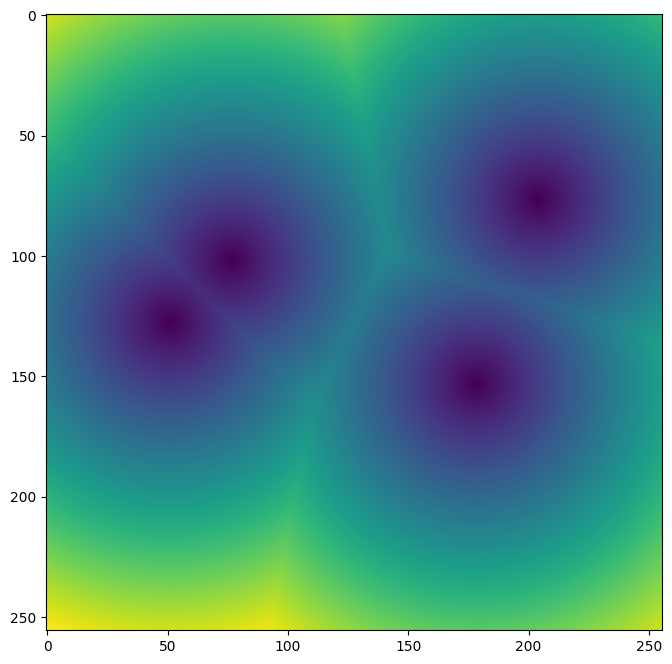

In [ ]:
# Case 2:
distance_to_data = min_dist([[0.4, 0.3], [0.6, 0.7], [0.3, 0.8], [0.5, 0.2]], 256)
plt.figure(figsize=(8, 8))
plt.imshow(distance_to_data)

# Part 3-1b: Batched version

As a next step, improve the `min_dist` function to support batches.
The `points` array is now expected to be a tensor with shape [batch_size, num_points, 3], generated by `create_points`.
`min_dist` should return a batch of maps with shape [batch_size, res, res].
Again, make sure to implement `min_dist` using **no for-loops**.
Demonstrate your function output with `batch_size=3` and `num_points=4`.

In [ ]:
def create_points(batch_size, num_points):
  coords = np.random.rand(batch_size, num_points, 2)
  return coords

In [ ]:
def min_dist(points, res):

  # Convert points to tensor
  points = torch.tensor(points, dtype=torch.float32)  # shape [batch_size, num_points, 2]

  # Create grid
  grid_x, grid_y = torch.meshgrid(torch.linspace(0, 1, res), torch.linspace(0, 1, res), indexing='ij')
  grid = torch.stack((grid_x, grid_y), dim=-1)  # shape [res, res, 2]
  grid_flat = grid.view(-1, 2)  # shape [res^2, 2]

  batch_distances = torch.cdist(grid_flat.unsqueeze(0), points)  # shape [batch_size, res^2, num_points]

  # Find min dist for each grid point over all data points
  min_distances = batch_distances.min(dim=-1).values  # shape [batch_size, res^2]

  # Reshape to [batch_size, res, res]
  min_distances_2d = min_distances.view(-1, res, res)

  return min_distances_2d

# Generate points
batch_size = 3
num_points = 4
resolution = 20

points = create_points(batch_size, num_points)
distance_maps = min_dist(points, resolution)

print("Points:", points)
print("Distance maps shape:", distance_maps.shape)

Points: [[[0.08153968 0.83431165]
  [0.86149726 0.9978701 ]
  [0.65999005 0.74916795]
  [0.26855601 0.01905882]]

 [[0.76964555 0.8321103 ]
  [0.75999795 0.98165924]
  [0.39722212 0.44795885]
  [0.82452554 0.79987007]]

 [[0.15312655 0.85370886]
  [0.70830775 0.4868044 ]
  [0.16004005 0.48680404]
  [0.66537842 0.29291962]]]
Distance maps shape: torch.Size([3, 20, 20])


# Part 3-2: Scalable version

Assume `res` can be very large (up to 65,536). Running the above function will likely cause the computer's RAM to be filled up, and fail (on a free colab instance, even 16,384 `res` will crash with `batch_size=3` and `num_points=4`).
Extend the above version of `min_dist` to calculate the result tensor at such high resolution without running out of RAM. This function may be less computationally efficient, as long as it can successfully run.

In [ ]:
def min_dist(points, res, chunk_size=1024):
    points = torch.tensor(points, dtype=torch.float32)  # shape [batch_size, num_points, 2]

    # Create grid
    grid_x, grid_y = torch.meshgrid(torch.linspace(0, 1, res), torch.linspace(0, 1, res), indexing='ij')
    grid = torch.stack((grid_x, grid_y), dim=-1).view(-1, 2)  # shape [res^2, 2]

    # Initialise output tensor
    output = torch.empty((points.shape[0], res, res), dtype=torch.float32)

    # Process the grid in chunks
    num_pixels = res * res
    for start in range(0, num_pixels, chunk_size):
        end = min(start + chunk_size, num_pixels)

        # Extract the chunk of grid points
        grid_chunk = grid[start:end]  # shape [chunk_size, 2]

        # Compute distances for the chunk
        distances = torch.cdist(grid_chunk.unsqueeze(0), points)  # shape [batch_size, chunk_size, num_points]

        # Find min distances for chunk
        min_distances = distances.min(dim=-1).values  # shape [batch_size, chunk_size]

        # Map back to the output tensor
        for batch_idx in range(points.shape[0]):
            output[batch_idx].view(-1)[start:end] = min_distances[batch_idx]

    return output


In [ ]:
# Generate points
batch_size = 3
num_points = 4
resolution = 16384  # High res

points = create_points(batch_size, num_points)
distance_maps = min_dist(points, resolution, chunk_size=4096)
print("Distance maps shape:", distance_maps.shape)


Distance maps shape: torch.Size([3, 16384, 16384])
